In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io.wavfile as sci_wav  # Open wav files
import os  # Manipulate files
# import warnings  # Warning removal
# warnings.filterwarnings('ignore')
from pickle import dump
from pickle import load
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout, Activation
from keras.models import Model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ROOT_DIR = '/Users/DM/FS/mod4/proj4/cats_dogs/'
X_path = os.listdir(ROOT_DIR)
y = [0 if 'cat' in f else 1 for f in X_path]  # change y to int values

In [3]:
X_path[0:5]

['cat_74.wav',
 'dog_barking_63.wav',
 'cat_60.wav',
 'dog_barking_77.wav',
 'cat_48.wav']

In [4]:
y[0:5]

[0, 1, 0, 1, 0]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_path, y, test_size=0.25)

In [6]:
print("in X, there is {} cats and {} dogs".format(len(y) - sum(y), sum(y)))
print("in X_train, there is {} cats and {} dogs".format(len(y_train) - sum(y_train), sum(y_train)))
print("in X_val, there is {} cats and {} dogs".format(len(y_val) - sum(y_val), sum(y_val)))

in X, there is 164 cats and 113 dogs
in X_train, there is 119 cats and 88 dogs
in X_val, there is 45 cats and 25 dogs


In [7]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths
    
    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [sci_wav.read(ROOT_DIR + f)[1] for f in wav_files]

print(read_wav_files('cat_1.wav'))
print(read_wav_files(['cat_1.wav', 'cat_2.wav']))

[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16)]
[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16), array([-1028, -1039, -1064, ...,     6,    38,     2], dtype=int16)]


In [8]:
X_train, X_val = map(read_wav_files, [X_train, X_val])

In [9]:
X_train[0:5]

[array([ -1,   0,   2, ..., 102,  53,  45], dtype=int16),
 array([   0,    0,    0, ..., -163, -403, -227], dtype=int16),
 array([  -1,   11,   11, ...,  256, 2151, 5192], dtype=int16),
 array([ 98, 141, 183, ..., 573, 632, 673], dtype=int16),
 array([-1,  0, -1, ..., 22, 22, 22], dtype=int16)]

In [10]:
for x in X_train[0:5]:
    print(x.shape)

(51420,)
(192000,)
(184000,)
(69056,)
(16614,)


In [11]:
ys = y_train[0:4]

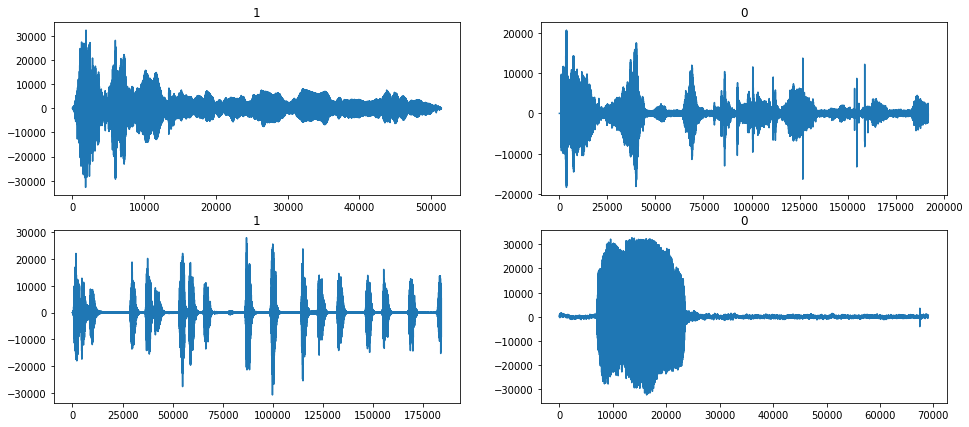

In [108]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].set_title(ys[0])
axs[0][0].plot(X_train[0])
axs[0][1].set_title(ys[1])
axs[0][1].plot(X_train[1])
axs[1][0].set_title(ys[2])
axs[1][0].plot(X_train[2])
axs[1][1].set_title(ys[3])
axs[1][1].plot(X_train[3])

In [13]:
max(X_train[1])

20626

In [14]:
X_train[5][0:50]

array([  782,   790,   746,   719,   807,   937,   945,  1079,  1165,
        1303,  1351,  1233,  1152,  1238,  1237,  1133,  1179,  1102,
         962,   817,   779,   720,   670,   505,   352,   230,   174,
          75,  -123,     3,    69,    13,    44,   -40,   -96,  -110,
        -155,  -269,  -487,  -476,  -561,  -660,  -568,  -774,  -840,
        -926,  -942,  -882,  -876, -1051], dtype=int16)

In [15]:
min(X_train[1])

-18328

In [16]:
def get_long_vectors(X, y):
    # Create two long 1D arrays with all the audio waves concatenated one after the other
    # (one for the cats, the other for the dogs)
    X_cat = np.concatenate([_x for _x, _y in zip(X, y) if _y == 0])
    X_dog = np.concatenate([_x for _x, _y in zip(X, y) if _y == 1])
    # Apply normalization (zero mean, std = 1)
    X_cat = preprocessing.scale(X_cat)
    X_dog = preprocessing.scale(X_dog)
    return X_cat, X_dog

In [17]:
def get_next_nonsilence(_X, sample_len, idx):
    # get a random starting point in the big array of sound values of for the correct animal
    # but make sure it is not too close to the end to fit a whole observation.  This seems to be an 
    # augmentation strategy: since the observation starting points are random, there may be overlap
    # among observations, but this is good: with enough epochs we'll get a big sample of randomly
    # shifted 1-second segments.
    x_idx = np.random.randint(len(_X) - sample_len)
    # the following is to check whether the 1-second observation contains only low-level noise
    # (i.e. the dog or cat is not making sound during that second).  The model should be using these
    # in neither training nor validation sets.  Predicting "dog" or "cat" from a second of silence is
    # not what we want the model to do.
    silence = True
    while silence == True:
        if max(_X[x_idx : x_idx + sample_len]) > 0.4:
            silence = False
            return x_idx
        else:
            x_idx = np.random.randint(len(_X) - sample_len)

In [18]:
def cats_and_dogs_gen(X = X_train, y = y_train, n_samples=20, sample_len=16000):
# n_samples: amount of samples per batch
# sample_len: size of the samples in a batch
    while True:
    # making the loop infininte so that the generator just keeps making more batches (required for keras)
        X_cat, X_dog = get_long_vectors(X, y)
        # find the higher of (number of cats,  number of dogs) and divide that by the batch size to get number
        # of batches needed, then loop through this number, creating all the batches (or rather, yielding
        # them one at a time as a generator)
        for _ in range(int(max(sum(y), len(y) - sum(y)) / n_samples)):
            # set up each batch
            y_batch = np.zeros(n_samples)
            X_batch = np.zeros((n_samples, sample_len))
            # for each observation in batch
            for idx in range(n_samples):
                # alternate zeros and ones for the y value of the batch
                y_batch[idx] = idx % 2
                # assign a source of sound values depending on the target already set (0 or 1) for the current batch
                _X = X_cat if y_batch[idx] == 0 else X_dog
                x_idx = get_next_nonsilence(_X, sample_len, idx) 
                X_batch[idx] = _X[x_idx : x_idx + sample_len]
            yield (X_batch.reshape(n_samples, sample_len, 1),
                   y_batch.reshape(-1, 1) )

In [56]:
model = models.Sequential()
model.add(layers.Conv1D(padding = 'same', filters = 10, kernel_size = 4, strides = 2, input_shape = (16000, 1)))
model.add(layers.BatchNormalization())
model.add(Activation("relu"))
# model.add(Dropout(0.2))
for i in range(9):
    model.add(layers.Conv1D(padding = 'same', filters = 10, kernel_size = 4, strides = 2))
    model.add(layers.BatchNormalization())
    model.add(Activation("relu"))
#     model.add(Dropout(0.2))
model.add(layers.GlobalAveragePooling1D())
# model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))

In [57]:
# model = load_model('audio6.h5')
# model.load_weights("best_weights6.hdf5")

In [58]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [59]:
filepath = "best_weights8.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 8000, 10)          50        
_________________________________________________________________
batch_normalization_11 (Batc (None, 8000, 10)          40        
_________________________________________________________________
activation_11 (Activation)   (None, 8000, 10)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 4000, 10)          410       
_________________________________________________________________
batch_normalization_12 (Batc (None, 4000, 10)          40        
_________________________________________________________________
activation_12 (Activation)   (None, 4000, 10)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 2000, 10)          410       
__________

In [61]:
history = model.fit_generator(
      cats_and_dogs_gen(),
      epochs = 15, steps_per_epoch = 75, validation_steps = 50,
      validation_data = cats_and_dogs_gen(X = X_val, y = y_val), callbacks = callbacks_list)

Epoch 1/15


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


75/75 [==============================] - 84s 1s/step - loss: 0.6874 - acc: 0.4687 - val_loss: 0.6455 - val_acc: 0.6320

Epoch 00001: val_acc improved from -inf to 0.63200, saving model to best_weights8.hdf5
Epoch 2/15
75/75 [==============================] - 85s 1s/step - loss: 0.6657 - acc: 0.5460 - val_loss: 0.6372 - val_acc: 0.6720

Epoch 00002: val_acc improved from 0.63200 to 0.67200, saving model to best_weights8.hdf5
Epoch 3/15
75/75 [==============================] - 85s 1s/step - loss: 0.6539 - acc: 0.5913 - val_loss: 0.6219 - val_acc: 0.6780

Epoch 00003: val_acc improved from 0.67200 to 0.67800, saving model to best_weights8.hdf5
Epoch 4/15
75/75 [==============================] - 83s 1s/step - loss: 0.6376 - acc: 0.6160 - val_loss: 0.6150 - val_acc: 0.6790

Epoch 00004: val_acc improved from 0.67800 to 0.67900, saving model to best_weights8.hdf5
Epoch 5/15
75/75 [==============================] - 83s 1s/step - loss: 0.6327 - acc: 0.6220 - val_loss: 0.6184 - val_acc: 0.6840


In [62]:
model.save('audio8.h5')

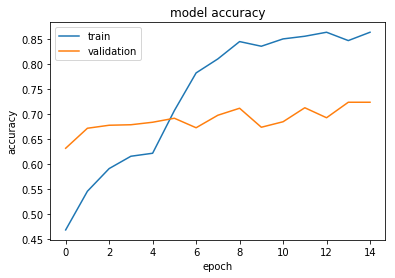

In [63]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [64]:
TEST_DIR = '/Users/DM/FS/mod4/proj4/audio-cats-and-dogs/test/'
test_path = os.listdir(TEST_DIR)
y_test = [0 if 'cat' in f else 1 for f in test_path]  # change y to int values

In [65]:
y_test

[1, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [66]:
test_path

['dog_barking_1.wav',
 'cat_164.wav',
 'cat_165.wav',
 'dog_barking_0.wav',
 'dog_barking_2.wav',
 'cat_167.wav',
 'cat_166.wav',
 'dog_barking_3.wav',
 'cat_163.wav',
 'dog_barking_4.wav']

In [67]:
X_test = list(map(read_wav_files, [test_path]))

In [68]:
X_test = X_test[0]

In [69]:
for x in X_test[0:5]:
    print(x.shape)

(185600,)
(163566,)
(182400,)
(275203,)
(190400,)


In [70]:
new_X_test = []
new_y_test = []
segments = []
running_sum = 0
segment_starts = []
for i in range(len(X_test)):
    x = preprocessing.scale(X_test[i])
    l = len(x)
    segs = l // 16000
    segments.append(segs)
    segment_starts.append(running_sum)
    running_sum += segs
    # ignores final second fraction
    for s in range(segs):
        new_X_test.append(x[s*16000:(s+1)*16000])
        new_y_test.append(y_test[i])    

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


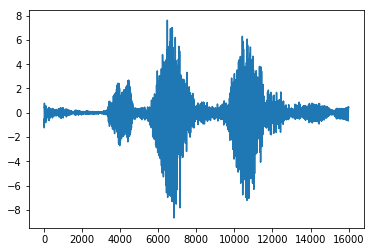

In [71]:
plt.plot(new_X_test[4])

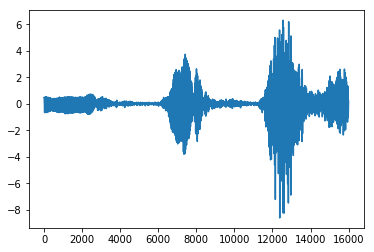

In [72]:
plt.plot(new_X_test[5])

In [73]:
len(new_y_test)

105

In [74]:
len(new_X_test)

105

In [75]:
reshaped_X_test = []
for x in new_X_test:
    q = x.reshape((16000,1))
    q = np.expand_dims(q, axis = 0)
    reshaped_X_test.append(q)

In [76]:
probas = []
for i in range(len(reshaped_X_test)):
    p = model.predict(reshaped_X_test[i])
    probas.append(p[0][0])

In [77]:
preds = []
for pr in probas:
    if pr > 0.5:
        preds.append(1)
    else:
        preds.append(0)

In [78]:
from sklearn.metrics import accuracy_score
ac = accuracy_score(new_y_test, preds)*100
print('final test accuracy: ', round(ac,1), '%') 

final test accuracy:  73.3 %


In [79]:
matches = []
over = []
for i in range(len(segment_starts)):
    m = np.mean(probas[segment_starts[i] : segment_starts[i] + segments[i]])
    if m > 0.5:
        o = 1
    else:
        o = 0
    over.append(o)
    if o == y_test[i]:
        matches.append(1)
    else:
        matches.append(0)

In [80]:
matches

[1, 1, 0, 1, 1, 0, 0, 1, 1, 1]

In [81]:
print('accuracy per audio clip:', round(100*sum(matches)/len(matches)), '%')

accuracy per audio clip: 70 %


In [82]:
over

[1, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [83]:
x, y = next(cats_and_dogs_gen())

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [84]:
y

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.]])

In [85]:
x.shape

(20, 16000, 1)

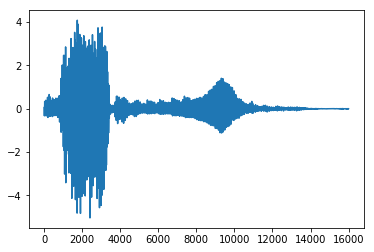

In [86]:
plt.plot(x[7, : ,0])
plt.show()

In [87]:
x = x[7, : , :]
x = np.expand_dims(x, axis = 0)

In [88]:
x.shape

(1, 16000, 1)

In [89]:
model.predict(x)

array([[0.88082314]], dtype=float32)

In [90]:
def make_plots(predict):
    fig, axs = plt.subplots(5, 2, figsize=(17,10))
    axs[0][0].plot(predict[0,:,0])
    axs[0][1].plot(predict[0,:,1])
    axs[1][0].plot(predict[0,:,2])
    axs[1][1].plot(predict[0,:,3])
    axs[2][0].plot(predict[0,:,4])
    axs[2][1].plot(predict[0,:,5])
    axs[3][0].plot(predict[0,:,6])
    axs[3][1].plot(predict[0,:,7])
    axs[4][0].plot(predict[0,:,8])
    axs[4][1].plot(predict[0,:,9])

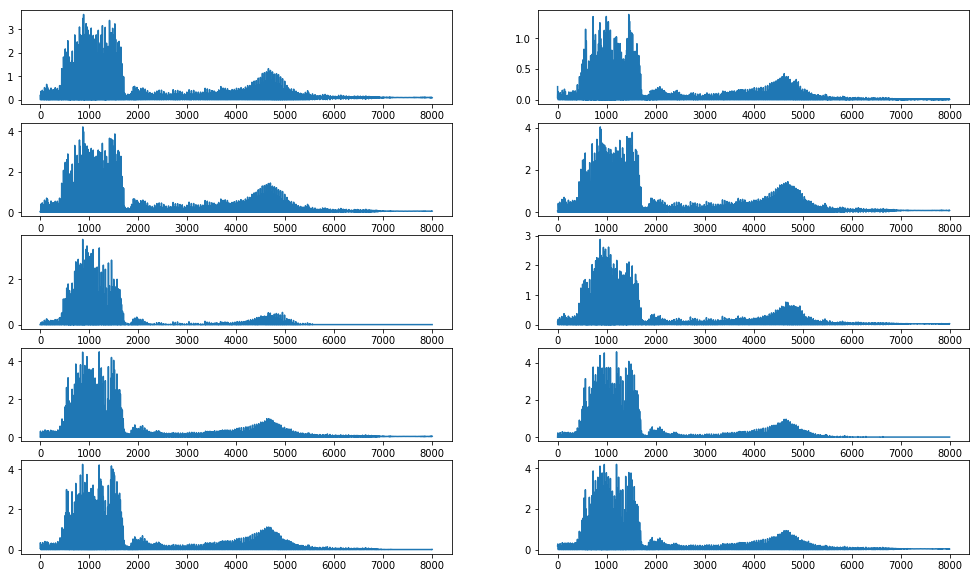

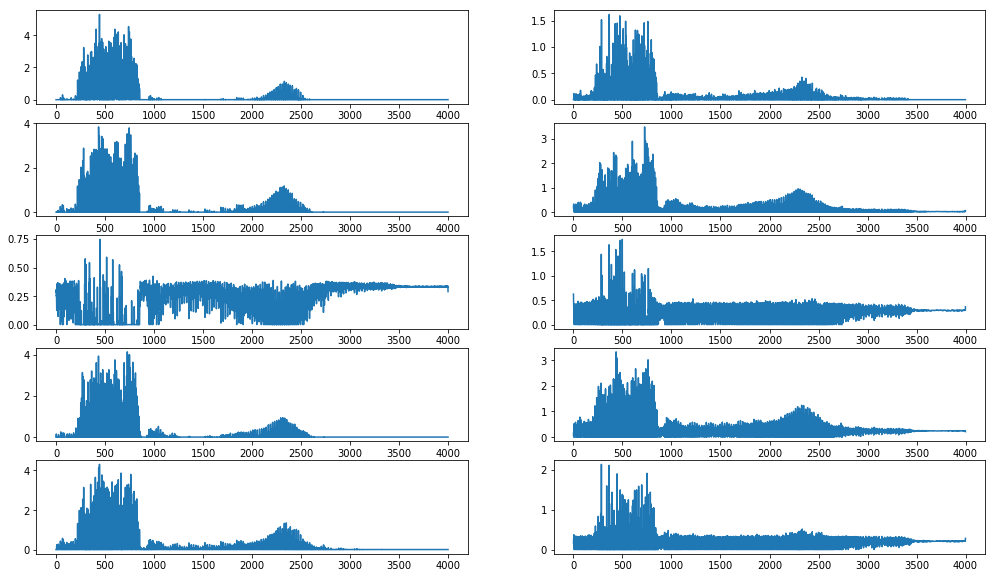

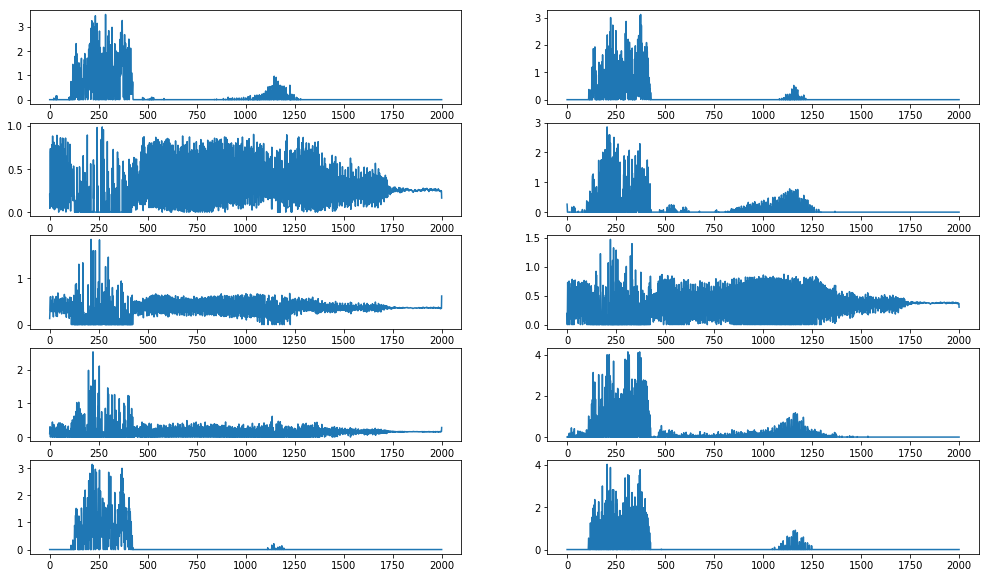

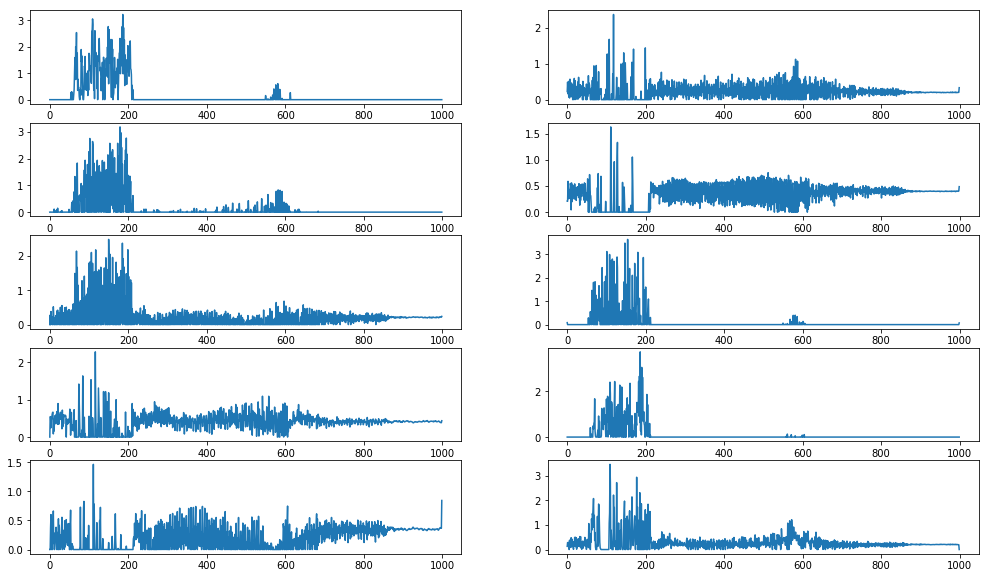

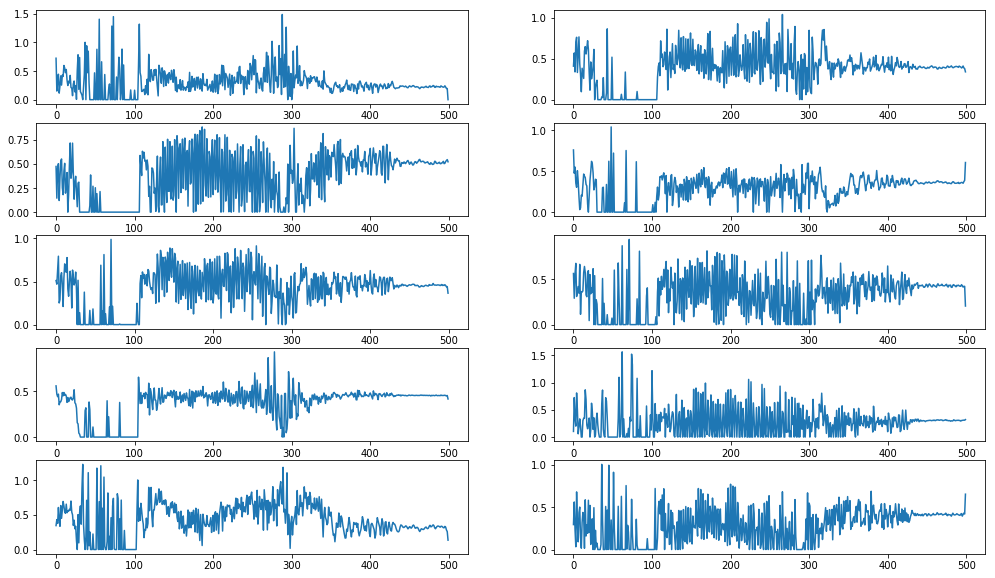

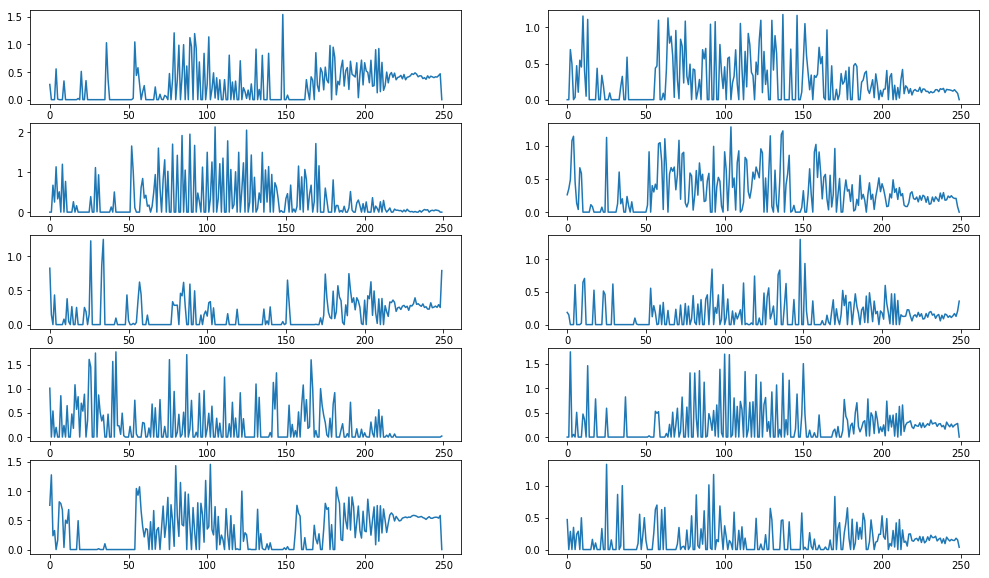

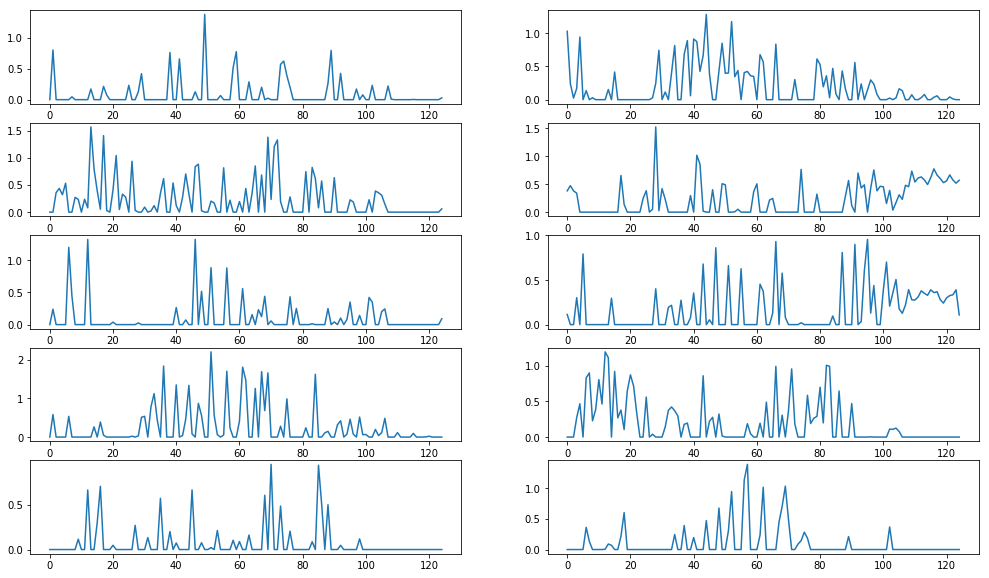

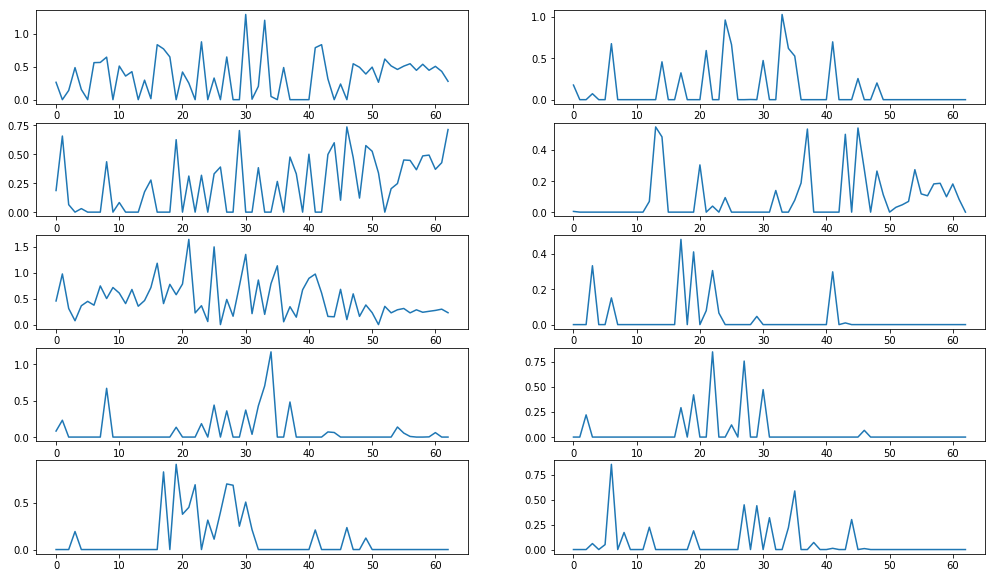

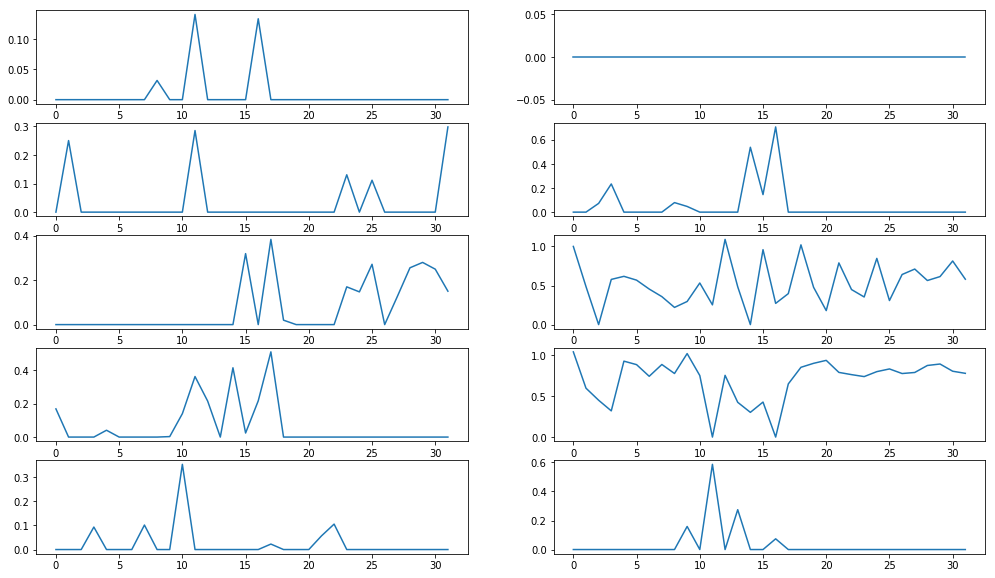

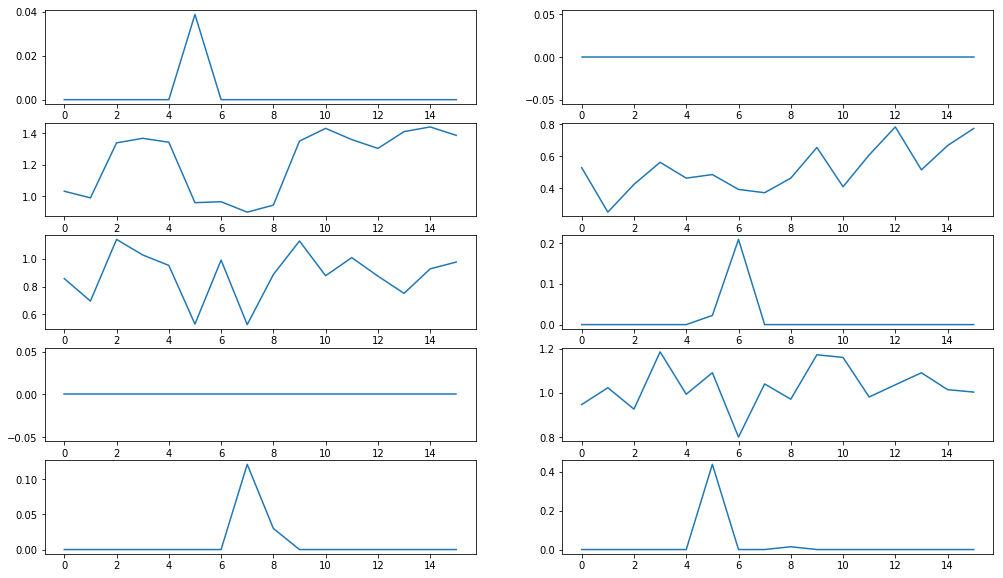

In [92]:
# does not work unless 10 filters in each layer
for i in range(1,11):
    layer_name = 'activation_' + str(10 + i)
    intermediate_layer_model = Model(inputs = model.input,
                                 outputs = model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(x)
    make_plots(intermediate_output)

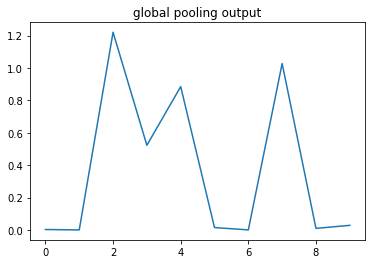

In [94]:
layer_name = 'global_average_pooling1d_2'
intermediate_layer_model = Model(inputs = model.input,
                                 outputs = model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(x)
i_o = intermediate_output[0, :]
plt.plot(i_o)
plt.title('global pooling output')
plt.show()

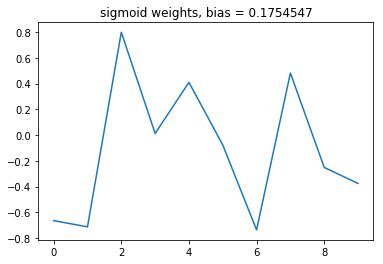

In [97]:
layer_name = 'dense_2'
weights = model.get_layer(layer_name).get_weights()[0]
bias = model.get_layer(layer_name).get_weights()[1]
plt.plot(weights)
plt.title('sigmoid weights, bias = ' + str(bias[0]))
plt.show()

In [109]:
layer_name = 'conv1d_11'
weights = model.get_layer(layer_name).get_weights()[0]
bias = model.get_layer(layer_name).get_weights()[1]
# plt.plot(weights)
# plt.title('sigmoid weights, bias = ' + str(bias[0]))
# plt.show()

In [110]:
weights.shape

(4, 1, 10)

In [114]:
big_list = []
for i in range(weights.shape[1]):
    for j in range(weights.shape[2]):
        four_list = []
        for k in range(weights.shape[0]):
            four_list.append(weights[k, i, j])
        big_list.append(four_list)

In [115]:
big_list

[[0.12726514, 0.32244226, 0.010760814, -0.17052032],
 [-0.2934963, 0.33112824, 0.14286487, -0.25592384],
 [0.31912702, 0.11909848, -0.02097666, 0.19213103],
 [0.23750453, -0.06859671, 0.2881193, 0.009821497],
 [-0.2520666, -0.16139841, 0.1839366, 0.25615573],
 [-0.21449064, 0.17552964, 0.16496074, -0.064870074],
 [-0.31260377, 0.013071916, -0.14043249, 0.13491118],
 [0.08459217, -0.051996168, -0.19972837, -0.2132581],
 [-0.21648633, -0.066860646, 0.2856413, -0.2547597],
 [-0.025606053, 0.12858449, 0.039769564, -0.32038367]]

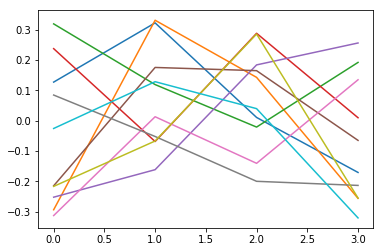

In [116]:
for l in big_list:
    plt.plot(l)